# Install
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install transformers datasets scikit-learn matplotlib seaborn tqdm pandas

Install PyTorch with CUDA support
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Install other libraries
pip install transformers datasets scikit-learn matplotlib seaborn tqdm pandas


# start

In [1]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

c:\Users\prisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load Data
df = pd.read_csv("data/text.csv")

# Visualize Data

C:\Users\prisa\AppData\Local\Temp\ipykernel_16680\78463982.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


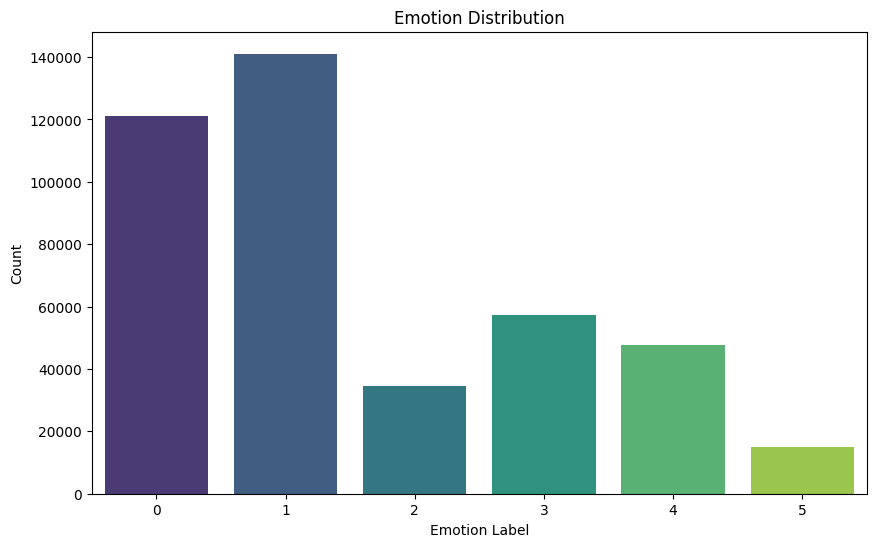

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Emotion Distribution')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.show()

# Data Preparation

In [5]:
df.duplicated().sum()

0

In [6]:
X = df['text'].tolist()
y = df['label'].tolist()

In [7]:
# Label encoding to numeric for BERT (if not already done)
unique_labels = sorted(set(y))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for i, label in enumerate(unique_labels)}
y = [label2id[label] for label in y]

# Dataset Preparation for PyTorch

In [8]:
# Define a custom dataset class for text classification
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [9]:
# Load pre-trained BERT tokenizer and model for sequence classification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(unique_labels)).to(device)


C:\Users\prisa\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# checkponit

In [ ]:
# Specify the checkpoint path
checkpoint_path = 'model_checkpoint.pth'

In [10]:
# Define a function to save the checkpoint, including fold and epoch
def save_checkpoint(model, optimizer, fold, epoch, accuracy_scores, classification_reports, confusion_matrices, checkpoint_path):
    state = {
        'fold': fold,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy_scores': accuracy_scores,
        'classification_reports': classification_reports,
        'confusion_matrices': confusion_matrices
    }
    torch.save(state, checkpoint_path)
    print(f"Checkpoint saved at fold {fold+1}, epoch {epoch+1} to {checkpoint_path}")

In [11]:
# Define a function to load from the checkpoint, including fold and epoch
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        fold = checkpoint['fold']
        epoch = checkpoint['epoch']
        accuracy_scores = checkpoint.get('accuracy_scores', [])
        classification_reports = checkpoint.get('classification_reports', [])
        confusion_matrices = checkpoint.get('confusion_matrices', [])
        print(f"Checkpoint loaded from {checkpoint_path}, resuming from fold {fold+1}, epoch {epoch+1}")
        return fold, epoch, accuracy_scores, classification_reports, confusion_matrices
    else:
        print(f"No checkpoint found at {checkpoint_path}, starting from scratch.")
        return 0, 0, [], [], []

In [12]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)

# Load the last checkpoint if it exists
start_fold, start_epoch, accuracy_scores, classification_reports, confusion_matrices = load_checkpoint(model, optimizer, checkpoint_path)


# K-Fold Cross-Validation and Training

In [14]:
# K-Fold Cross-Validation and Training
kf = KFold(n_splits=5, shuffle=True, random_state=0)


In [16]:
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    if fold < start_fold:
        continue  # Skip folds that have already been completed

    print(f"Fold {fold + 1}/{kf.get_n_splits()}")

    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    # Create PyTorch Datasets
    train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, max_len=128)
    test_dataset = TextClassificationDataset(X_test, y_test, tokenizer, max_len=128)

    # Create DataLoader for batching
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Learning rate scheduler
    num_training_steps = len(train_loader) * 3  # 3 epochs
    lr_scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    # Resume training from the checkpoint's epoch
    for epoch in range(start_epoch, 3):  # 3 epochs per fold
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        model.train()

        for batch in progress_bar:
            optimizer.zero_grad()

            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"loss": running_loss / len(train_loader)})

        # Save the checkpoint after each epoch along with metrics
        save_checkpoint(model, optimizer, fold, epoch + 1, accuracy_scores, classification_reports, confusion_matrices, checkpoint_path)

        print(f"Epoch {epoch + 1} completed for Fold {fold + 1}")

    # Evaluation loop
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(batch['labels'].cpu().numpy())

    # Calculate accuracy, classification report, and confusion matrix
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    classification_reports.append(classification_report(y_true, y_pred, target_names=unique_labels, output_dict=True))
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

    # Reset start_epoch for the next fold
    start_epoch = 0

Fold 1/5


Training Epoch 1:   0%|          | 0/20841 [00:00<?, ?it/s]C:\Users\prisa\AppData\Roaming\Python\Python312\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Training Epoch 1:   2%|▏         | 326/20841 [01:45<1:50:26,  3.10it/s, loss=0.0124] 


KeyboardInterrupt: 

# Model Evaluation

In [ ]:
# Print average accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"\nAverage Accuracy across folds: {avg_accuracy:.4f}")

# Print classification reports and confusion matrices for each fold
for i, report in enumerate(classification_reports):
    print(f"\nClassification Report for Fold {i+1}:\n")
    print(pd.DataFrame(report).transpose())

for i, matrix in enumerate(confusion_matrices):
    print(f"\nConfusion Matrix for Fold {i+1}:\n")
    print(matrix)